#Latent-Based Regression through GAN Semantics

This notebook contains an example playground for the paper: LARGE: Latent-Based Regression through GAN Semantics

We currently support both sorting and regression models. Expand the relevant section for more info.


In [ ]:
#@title Setup required packages, models. This may take a few minutes.

import os

data_dir        = os.path.join("/content", "latent_regression")
celeba_dir      = os.path.join(data_dir, "celeba_images")
latents_dir     = os.path.join(data_dir, "latents")
cat_dir         = os.path.join(data_dir, "afhq_cat_images")
cat_latents_dir = os.path.join(data_dir, "cat_latents")

# install requirements
!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

!git clone https://github.com/omertov/encoder4editing.git
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

!git clone https://github.com/YotamNitzan/LARGE.git

!gdown --id 1WqhoitsRZ2nfUslIMf5Rg_WWOp2LW2Hu

!unzip -q latent_regression.zip
!unzip -q latent_regression/celeba_images.zip -d $celeba_dir
!unzip -q latent_regression/latents.zip -d $latents_dir
!unzip -q latent_regression/afhq_cat_images -d $cat_dir
!unzip -q latent_regression/afhq_cat_latents -d $cat_latents_dir

%load_ext autoreload
%autoreload 2


In [ ]:
#@title General imports and variables
from PIL import Image

import sys

import numpy as np

set_feature_directions = {"celebA": "precomputed_feature_dirs.npy",
                          "afhq_cat": "precomputed_cat_feature_dirs.npy"}

set_num_layers = {"celebA": 18,
                  "afhq_cat": 16}

# Sorting




Sorting in broken into two parts:


1.   Choose a semantic direction. Currently supported options are:
    *   Choose a direction from the paper
    *   Create your own using a StyleCLIP-based approach
    *   Upload a boundary file

2.   Run the sorting script.

## 1) Choose a latent direction:







### Precomputed paper directions:

In [ ]:
#@title Precomputed boundaries:

boundary = 'celebA_hair_color' #@param['celebA_hair_length', 'celebA_hair_color', 'celebA_makeup', 'celebA_expression', 'cat_age', 'cat_yaw', 'cat_pitch']

dataset = boundary.split("_")[0]
if dataset == "cat":
    dataset = "afhq_cat"

clip_boundary_dir = os.path.join(data_dir, "clip_boundaries")
sefa_boundary_dir = os.path.join(data_dir, "sefa_boundaries")

boundary_type = {"celebA": "s", "afhq_cat": "w"}[dataset]
latent_src = "e4e"
latent_type = {"celebA": "s_latents", "afhq_cat": "latents"}[dataset]
boundary_ext = {"celebA": ".pickle", "afhq_cat": ".npy"}[dataset]

boundary_path = {"celebA_hair_length": os.path.join(clip_boundary_dir, "short_to_long_S_10"),
                 "celebA_hair_color":  os.path.join(clip_boundary_dir, "black_to_blonde_S"),
                 "celebA_makeup":      os.path.join(clip_boundary_dir, "makeup_S"),
                 "celebA_expression":  os.path.join(clip_boundary_dir, "sad_to_smile_S"),
                 "cat_age":            os.path.join(sefa_boundary_dir, "cat_age"),
                 "cat_yaw":            os.path.join(sefa_boundary_dir, "cat_yaw"),
                 "cat_pitch":          os.path.join(sefa_boundary_dir, "cat_pitch")}[boundary]

boundary_path = os.path.join(boundary_path, f'boundary{boundary_ext}')

### Create your own direction with StyleCLIP:

*   Enter source and target texts which describe the sorting direction.
*   Choose a cutoff value for considered directions. A higher value gives a more disentangled direction, at the risk of removing too much relevant information.



In [ ]:
#@title Generate a StyleCLIP boundary:

dataset = 'afhq_cat' #@param['celebA', 'afhq_cat']

source_text = "white fur" #@param {type: "string"}
target_text = "black fur" #@param {type: "string"}

cutoff_percentile = 80 #@param {type: "integer"}

boundary_type = "w+"
latent_src = "psp"
latent_type = "latents"
boundary_ext = ".npy"
clip_boundary_dir = os.path.join(data_dir, "clip_boundaries")

feature_dir_file = set_feature_directions[dataset]

num_layers = set_num_layers[dataset]

feature_dirs_file = os.path.join(clip_boundary_dir, feature_dir_file)

boundary = "live_editing"

!python LARGE/get_clip_boundary.py --source_text "$source_text" --target_text "$target_text" --name $boundary --precomputed_dirs $feature_dirs_file --out_dir $clip_boundary_dir --cutoff_percentile $cutoff_percentile --model_layers $num_layers

boundary_path = os.path.join(clip_boundary_dir, boundary, f"boundary{boundary_ext}")

print(f"Done! The generated boundary can be found in: {boundary_path}")



### Upload your own boundary:

The boundary should describe a direction in one of the latent spaces of StyleGAN2. We currently support boundaries in a numpy (npy) and pickle format, and in either W, W+ or S space.

In [ ]:
dataset = 'afhq_cat' #@param['celebA', 'afhq_cat']

boundary_path = "" #@param {type: "string"}

boundary_type = "w" #@param['w', 'w+', 's']
latent_src  = "psp" if boundary_type == "w+" else "e4e"
latent_type = "latents"

In [15]:
!python LARGE/sort.py


usage: sort.py [-h] [--latent_path LATENT_PATH] [--image_path IMAGE_PATH] --boundary_path
               BOUNDARY_PATH [--negative_boundary_path NEGATIVE_BOUNDARY_PATH]
               [--latent_file_ext {.pickle,.pkl,.npy}] [--num_samples NUM_SAMPLES]
               [--balanced_classes BALANCED_CLASSES [BALANCED_CLASSES ...]]
               [--num_for_plot NUM_FOR_PLOT] --out_dir OUT_DIR
               [--layer_weights_path LAYER_WEIGHTS_PATH] [--boundary_to_wp] [--seed SEED]
               [--model_layers MODEL_LAYERS] [--distance_type {per_layer,euclidean}]
               [--resize_output RESIZE_OUTPUT [RESIZE_OUTPUT ...]] [--weighted_edges {True,False}]
sort.py: error: the following arguments are required: --boundary_path, --out_dir


## 2) Sort!

Pick a seed and run the block in order to sort a random subset of CelebA according to your chosen semantic boundary.

In [19]:
seed = 2  # Random seed
high_variance_samples = True  # Choose high variance samples or not

latents = cat_latents_dir if dataset == "afhq_cat" else os.path.join(latents_dir, latent_src, dataset, latent_type)
images = cat_dir if dataset == "afhq_cat" else celeba_dir

output_dir = os.path.join("sorted", boundary)
os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists

if high_variance_samples:
    weighted_edges = True
    num_samples = 100
else:
    weighted_edges = False
    num_samples = 10

num_layers = set_num_layers[dataset]

to_w_flag = "--boundary_to_w" if boundary_type == 'w' else ''  # Ensure correct flag
boundary_path = "path/to/boundary"  # Ensure this path is correctly set

# Run the sorting script
cmd = f"python LARGE/sort.py --latent_path {latents} --image_path {images} --boundary_path {boundary_path} "
cmd += f"--num_samples {num_samples} --out_dir {output_dir} --seed {seed} --num_for_plot 10 {to_w_flag} "
cmd += f"--model_layers {num_layers} --weighted_edges {weighted_edges}"
os.system(cmd)  # Execute the script

# Ensure the output image exists before opening
sorted_image_path = os.path.join(output_dir, "all_sorted.jpg")
if os.path.exists(sorted_image_path):
    Image.open(sorted_image_path).show()
else:
    print(f"Error: File {sorted_image_path} was not created.")


Error: File sorted/live_editing/all_sorted.jpg was not created.


# Regression

For regression - first train a model using labeled CelebA data, then run inference on images from the CelebA test split or an uploaded image of your own.

### Train a regression model

We currently support pose and age models, using the labels from the paper

In [20]:
model_type = 'pose' #@param['pose', 'age']

latents_path = os.path.join(latents_dir, "e4e", "celebA", "latents")

annotation_file = {"pose": "celeba_yaw.csv", "age": "celeba_age.csv"}[model_type]
boundary_path = {"pose": "pose_boundary", "age": "clip_boundaries/old_to_young_WP"}[model_type]
attribute = {"pose": "yaw", "age": "Young"}[model_type]

w_boundary_flags = f"--boundary_to_wp --layer_weights_path {data_dir}/{boundary_path}/layer_weights.npy" if model_type == "pose" else ""
distance_type_flags = "" if model_type == "pose" else "--distance_type euclidean"

!python LARGE/train_regression_model.py --data-path $latents_path --annotations-file $data_dir/labels/$annotation_file --boundary_path $data_dir/$boundary_path $w_boundary_flags --attribute $attribute --output-dir $data_dir/regression_models/ --regularization L1 L2 --feature_sample_ratio 0.95 $distance_type_flags

Preparing data...
/content/LARGE/train_regression_model.py:247: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(args.annotations_file, delim_whitespace=True, header=0)
29978it [00:01, 19860.19it/s]
1000it [00:00, 1106.28it/s]
3493it [00:02, 1516.37it/s]
All data loaded. Total samples: 1000
Taking just the 95.0% center data. Samples remaining: 950
Working in latent space: LatentSpace.WP
Using layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
100% 1000/1000 [00:02<00:00, 463.71it/s]
For n=2: there were 988 unique groups sampled
For n=2, with min distance: 47.92783020102877. MAE - 4.3 +- 1.2 (13.5)
100% 1000/1000 [00:03<00:00, 279.58it/s]
For n=5: there were 1000 unique groups sampled
For n=5, with min distance: 14.563499884220432. MAE - 3.59 +- 0.577 (7.27)
100% 1000/1000 [00:02<00:00, 339.35it/s]
For n=10: there were 1000 unique groups sampled
For n=10, w

### Invert an image into the latent space of the GAN, or choose a pre-inverted image:

#### Choose a pre-inverted image (skip if you want to invert your own)

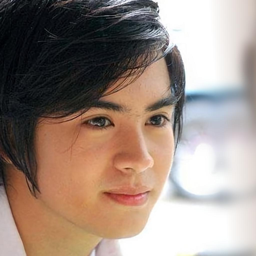

In [21]:
image_files = os.listdir(celeba_dir)
image_paths = [os.path.join(celeba_dir, file_name) for file_name in image_files]

latent_type = "w+" #@param['w+', 's']
latent_dir_name = "s_latents" if latent_type == 's' else "latents"

latents = [os.path.join(latents_dir, "e4e", "celebA", latent_dir_name, file_name.split(".")[0] + ".pickle") for file_name in image_files]

image_id = 731 #@param {type:"slider", min:1, max:4500, step:1}

chosen_latent = latents[image_id - 1]
chosen_img = image_paths[image_id - 1]

img = Image.open(chosen_img)
img.resize((256, 256))

#### Invert an image (skip if you picked a pre-inverted image)

##### Setup e4e for inversion. Skip if you want to use a pre-inverted image.

In [31]:
!python LARGE/explore_latent_channel_strength.py
!python LARGE/get_clip_boundary.py
!python LARGE/train_regression_model.py
!python LARGE/infer.py

/content/LARGE/explore_latent_channel_strength.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args.ckpt, map_location=self.device)
Traceback (m

In [32]:
#@title e4e setup
e4e_dir = os.path.join("/content", "encoder4editing")
sys.path.append(e4e_dir)

from models.psp import pSp
from gdown import download as drive_download

import torch
from torchvision import transforms
from argparse import Namespace

e4e_model_path = os.path.join(e4e_dir, "e4e_ffhq_encode.pt")
if not os.path.isfile(e4e_model_path):
    drive_download("https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P", e4e_model_path, quiet=False)
experiment_type = 'ffhq_encode'

# os.chdir('/content/encoder4editing')

EXPERIMENT_ARGS = {
        "model_path": e4e_model_path
    }
EXPERIMENT_ARGS['transform'] = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
resize_dims = (256, 256)

model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']

# update the training options
opts['checkpoint_path'] = model_path
opts = Namespace(**opts)
e4e_net = pSp(opts)
e4e_net.eval()
e4e_net.cuda()
print('Model successfully loaded!')

<ipython-input-32-2d43ca0ebb86>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path, map_location='cpu')


Loading e4e over the pSp framework from checkpoint: /content/encoder4editing/e4e_ffhq_encode.pt


/content/encoder4editing/models/psp.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(self.opts.checkpoint_path, map_location='cpu')


Model successfully loaded!


##### Choose and align an image for inversion. Skip if you want to use a pre-inverted image.

--2025-02-02 18:46:46--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-02-02 18:46:47--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  34.1MB/s    in 1.8s    

2025-02-02 18:46:48 (34.1 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

Aligned image has shape: (256, 256)


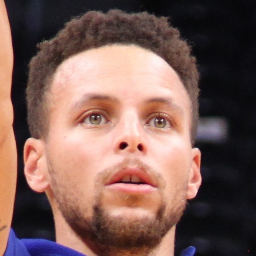

In [34]:
#@title Align image
image_path = "latent_regression/sample_image/sample.jpg" #@param {type: "string"}
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
if experiment_type == "ffhq_encode" and 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor)
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image

if experiment_type == "ffhq_encode":
  input_image = run_alignment(image_path)
else:
  input_image = original_image

input_image.resize(resize_dims)

##### Invert the aligned image. Skip if you want to use a pre-inverted image.

torch.Size([1, 18, 512])


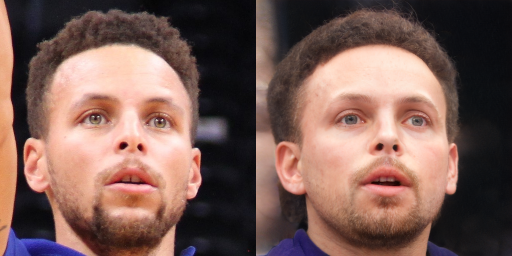

In [35]:
#@title Invert the image

from utils.common import tensor2im

img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    if experiment_type == 'cars_encode':
        images = images[:, :, 32:224, :]
    return images, latents

with torch.no_grad():
    images, latents = run_on_batch(transformed_image.unsqueeze(0), e4e_net)
    result_image, latent = images[0], latents[0]

print(latents.size())

chosen_latent = os.path.join("/content", "latent.npy")
chosen_img = image_path

np.save(chosen_latent, latents.detach().cpu().numpy())

# Display inversion:
display_alongside_source_image(tensor2im(result_image), input_image)

### Predict semantic property strength using the trained regression model

In [37]:
num_training_images = 1000 #@param[2, 5, 10, 20, 1000]

model_file = f"model_{num_training_images}.pickle"

!python LARGE/infer.py --pretrained_model $data_dir/regression_models/$model_file --latent_path "$chosen_latent" --boundary_path $data_dir/$boundary_path/boundary.npy $w_boundary_flags $distance_type_flags

Using regression model checkpoint from /content/latent_regression/regression_models/model_1000.pickle...
Loading boundary from /content/latent_regression/pose_boundary/boundary.npy...
Predicted score for atttribute: -8.96
